In [25]:
# Necessary Imports
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
import plotly.express as px
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [40]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 20

In [41]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 2000 files belonging to 2 classes.


In [42]:
class_names = dataset.class_names
n_classes = len(class_names)
class_names

['NORMAL', 'PNEUMONIA']

(32, 128, 128, 3)


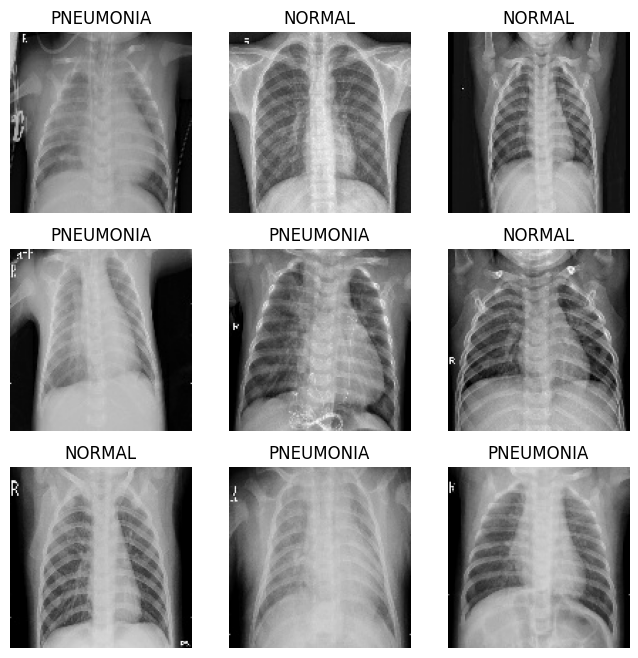

In [43]:
plt.figure(figsize=(8, 8))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    # print(label_batch.numpy())
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label_index = int(label_batch[i].numpy())
        plt.title(class_names[label_index])
        plt.axis("off")

plt.show()

In [45]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [46]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [47]:
print("Length of train_ds:", len(train_ds))
print("Length of val_ds:", len(val_ds))
print("Length of test_ds:", len(test_ds))

Length of train_ds: 50
Length of val_ds: 6
Length of test_ds: 7


In [48]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### **Normalize the Image**

In [49]:
resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)
])

In [50]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [51]:
dense_units = 128
dropout_rate = 0.5
learning_rate = 0.0001

In [52]:
def build_model():
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

    # MobileNetV2 Base Model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    base_model.trainable = False  # Freeze base model layers

    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)  # Rescale the images
    x = base_model(x, training=False)
    x = layers.Flatten()(x)

    # Dense layer and Dropout
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    outputs = layers.Dense(len(class_names), activation='softmax')(x)

    model = Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

# Build the model
model = build_model()

In [53]:
# Callbacks for early stopping and model checkpointing
checkpoint = ModelCheckpoint('saved_models/Chest_Disease_Classifier_Model.h5', save_best_only=True, verbose=1)

# Fit the model with the best hyperparameters
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 0.4184 - accuracy: 0.8491
Epoch 1: val_loss improved from inf to 0.16732, saving model to saved_models\Chest_Disease_Classifier_Model.h5


d:\Chest-X-Ray-Disease_Detection_using_CNN\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 26s 424ms/step - loss: 0.4184 - accuracy: 0.8491 - val_loss: 0.1673 - val_accuracy: 0.9427
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9312
Epoch 2: val_loss did not improve from 0.16732
50/50 [==============================] - 18s 357ms/step - loss: 0.1799 - accuracy: 0.9312 - val_loss: 0.1706 - val_accuracy: 0.9479
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.1323 - accuracy: 0.9426
Epoch 3: val_loss improved from 0.16732 to 0.12806, saving model to saved_models\Chest_Disease_Classifier_Model.h5
50/50 [==============================] - 18s 367ms/step - loss: 0.1323 - accuracy: 0.9426 - val_loss: 0.1281 - val_accuracy: 0.9531
Epoch 4/20
50/50 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9596
Epoch 4: val_loss improved from 0.12806 to 0.06493, saving model to saved_models\Chest_Disease_Classifier_Model.h5
50/50 [==============================] - 18s 

In [54]:
# Evaluate on test data
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1]*100:.2f}%")
print(f"Test Loss: {scores[0]:.4f}")

7/7 [==============================] - 3s 241ms/step - loss: 0.0242 - accuracy: 0.9911
Test Accuracy: 99.11%
Test Loss: 0.0242


In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#### **Training and Validation Metrics**

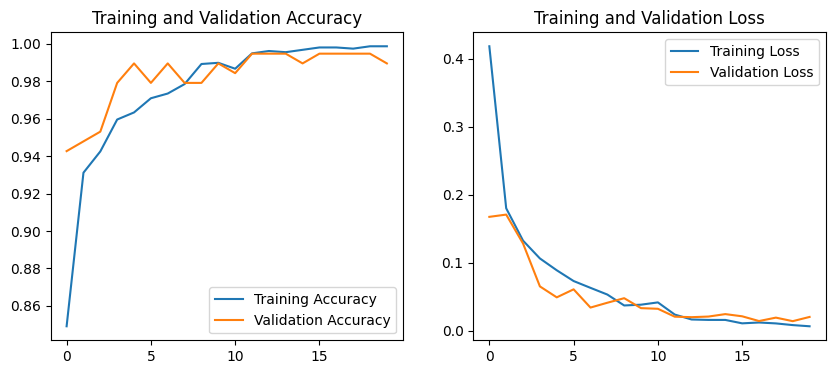

In [56]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 1s 1s/step


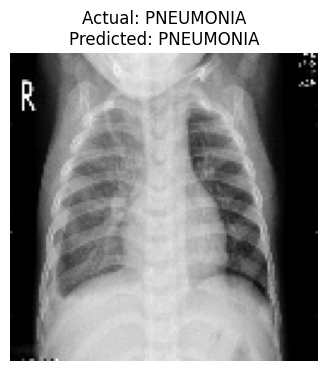

In [57]:
for image_batch, labels_batch in test_ds.take(1):
    image = image_batch[0].numpy().astype("uint8")
    
    # Actual label
    actual_label = int(labels_batch[0].numpy())
    actual_label_name = class_names[actual_label]
    
    # Predicted label
    batch_prediction = model.predict(image_batch)
    predicted_label = np.argmax(batch_prediction[0])  
    predicted_label_name = class_names[predicted_label]
    
    # Display the image with actual and predicted labels
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"Actual: {actual_label_name}\nPredicted: {predicted_label_name}")
    plt.axis('off')
    plt.show()

In [58]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)

    # Use np.argmax to get the index of the highest probability
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    confidence = round(100 * predictions[0][predicted_class_index], 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 53ms/step


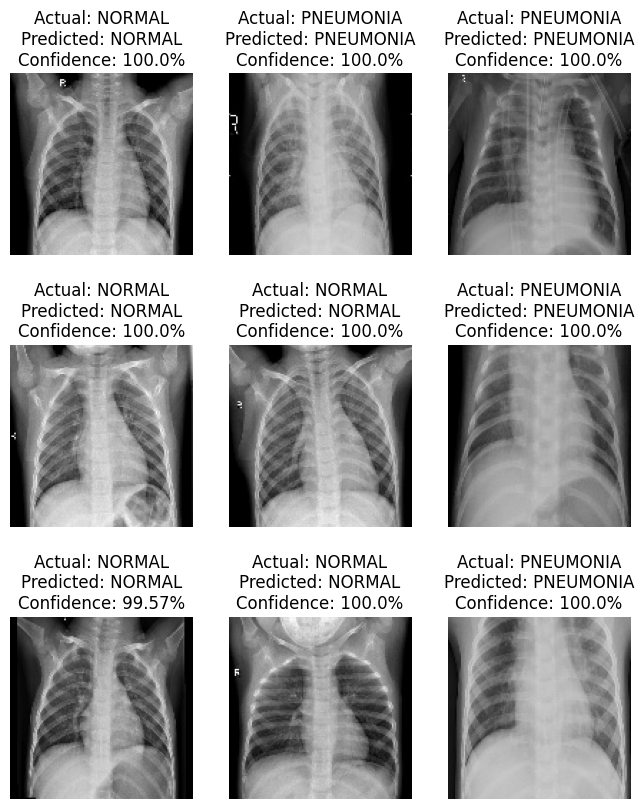

In [59]:
plt.figure(figsize=(8, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Predict the class and confidence
        predicted_class, confidence = predict(model, images[i].numpy())

        # Get the actual class
        actual_class = class_names[int(labels[i].numpy())]
        
        # Set the title with actual and predicted labels
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")
plt.show()

In [60]:
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for images, labels in test_ds:
    for i in range(len(images)):
        # Get the true label for the image
        true_label = class_names[int(labels[i].numpy())]
        true_labels.append(true_label)

        # Predict the label for the image using the predict function
        predicted_label, _ = predict(model, images[i].numpy())
        predicted_labels.append(predicted_label)

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)
print(cm)

1/1 [==============================] - 0s 52ms/step
[[111   1]
 [  1 111]]


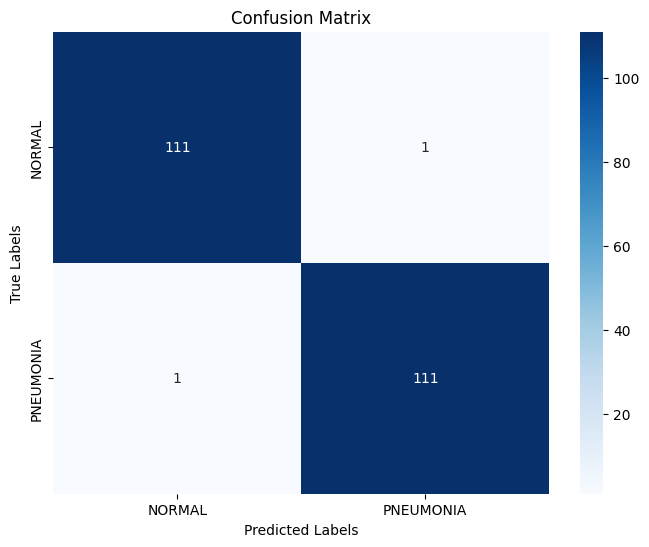

In [61]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [62]:
model.save('saved_models/Chest_Disease_Classifier_Model.keras')

In [63]:
MODEL = load_model('saved_models/Chest_Disease_Classifier_Model.keras')

1/1 [==============================] - 0s 59ms/step


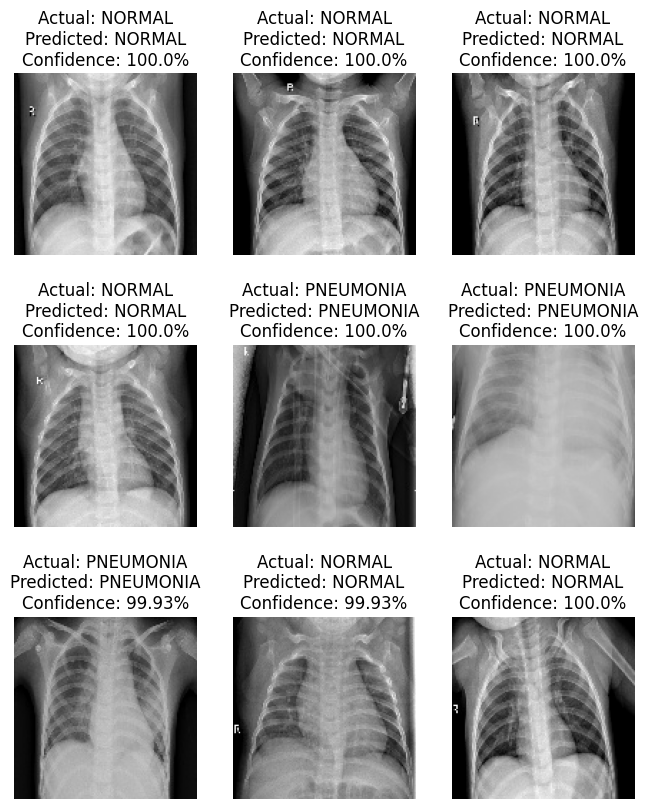

In [65]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the Keras model
MODEL = load_model('saved_models/Chest_Disease_Classifier_Model.keras')
class_names = ['NORMAL', 'PNEUMONIA']

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)

    # Use np.argmax to get the index of the highest probability
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    confidence = round(100 * predictions[0][predicted_class_index], 2)
    return predicted_class, confidence

# Assuming test_ds is your test dataset
plt.figure(figsize=(8, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Predict the class and confidence
        predicted_class, confidence = predict(MODEL, images[i].numpy())

        # Get the actual class
        actual_class = class_names[int(labels[i].numpy())]
        
        # Set the title with actual and predicted labels
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")
plt.show()

### **Model Post-training qunatization**

In [66]:
converter = tf.lite.TFLiteConverter.from_keras_model(MODEL)
tflite_model = converter.convert()

# Apply default optimization (post-training quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpafhfwzqq\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpafhfwzqq\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmp2rslj8v8\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmp2rslj8v8\assets


In [67]:
len(tflite_quant_model)

5130848

#### **Save the Qunatized Model**

In [68]:
# Save the qunatized model
with open('saved_models/Chest_Disease_Classifier_Model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

#### **Load the Quantized model and Predict the diseases**

In [69]:
def load_tflite_model(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter

def predict_and_plot_images(interpreter, test_ds, class_names, num_images=9):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    plt.figure(figsize=(15, 11))
    images_displayed = 0

    for images, labels in test_ds:
        if images_displayed >= num_images:
            break
        for i in range(images.shape[0]):
            if images_displayed >= num_images:
                break

            # Preprocess and predict
            input_data = np.expand_dims(images[i].numpy(), axis=0).astype(np.float32)
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # Get prediction and confidence
            predicted_label = class_names[np.argmax(output_data[0])]
            confidence = np.max(output_data[0]) * 100

            # Plot the image with label and confidence
            plt.subplot(3, 3, images_displayed + 1)

            image_to_display = images[i].numpy()
            if image_to_display.max() > 1:
                image_to_display /= 255.0

            plt.imshow(image_to_display)
            plt.title(f"Pred: {predicted_label}, Conf: {confidence:.2f}%\nTrue: {class_names[int(labels[i].numpy())]}")
            plt.axis('off')

            images_displayed += 1

    plt.show()

In [70]:
def evaluate_tflite_model(interpreter, test_ds, class_names):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    correct_predictions = 0
    total_samples = 0

    for images, labels in test_ds:
        for i in range(images.shape[0]):
            input_data = np.expand_dims(images[i].numpy(), axis=0).astype(np.float32)
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])

            predicted_label = np.argmax(output_data[0])
            correct_predictions += (predicted_label == int(labels[i].numpy()))
            total_samples += 1

    accuracy = correct_predictions / total_samples
    print(f"TFLite model accuracy: {accuracy * 100:.2f}%")

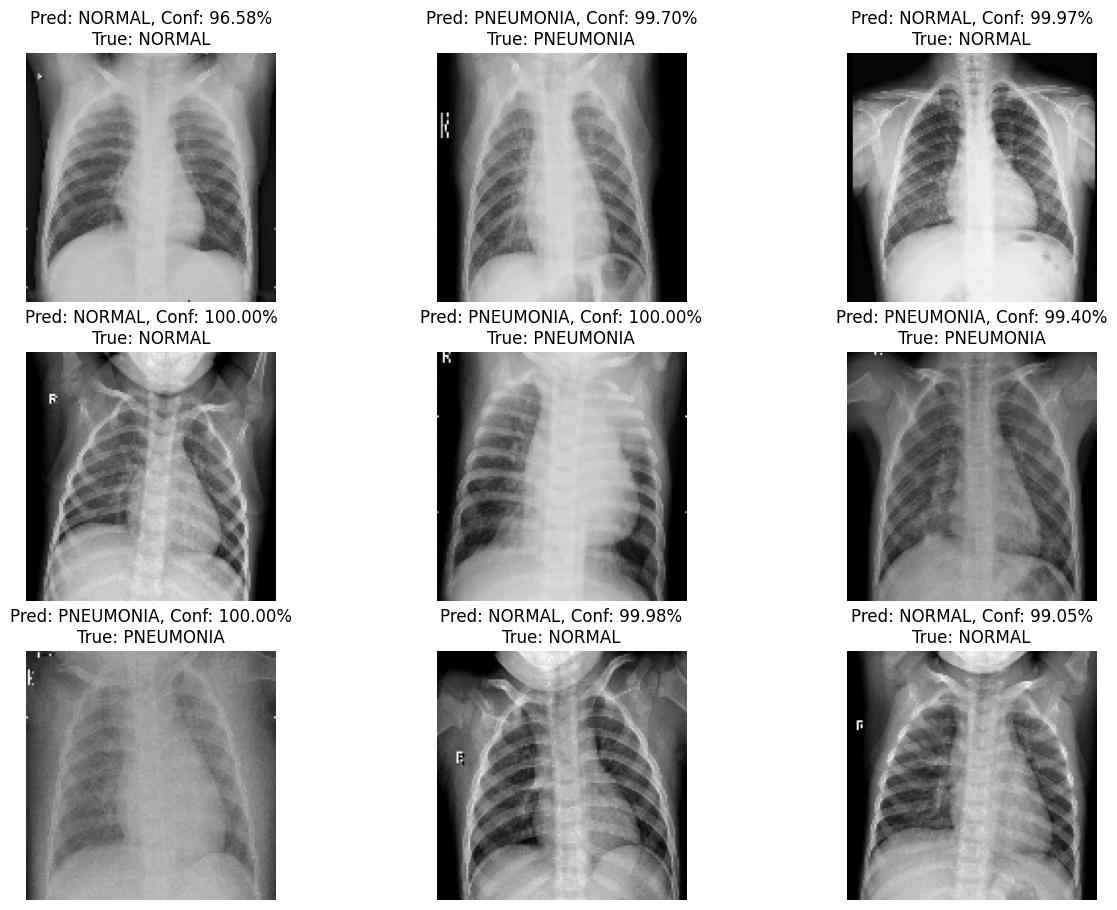

TFLite model accuracy: 99.11%


In [71]:
# Load the TFLite model
interpreter = load_tflite_model('saved_models/Chest_Disease_Classifier_Model.tflite')

# Predict and plot images with labels and confidence scores
predict_and_plot_images(interpreter, test_ds, class_names)

# Evaluate the TFLite model accuracy
evaluate_tflite_model(interpreter, test_ds, class_names)